In [93]:
from openai import OpenAI
import os
from datasets import load_dataset
import random
import math
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import math
import base64
import csv
import json
import seaborn as sns
import pandas as pd
sns.set_style('whitegrid')

SEED = 42
random.seed(SEED)


In [94]:
client=OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

In [3]:
# 'star' is a column in the dataset 

from datasets import ClassLabel # represent categorical class labels
# Loading the 'app_reviews' dataset's training split into the dataset variable
dataset=load_dataset('app_reviews',split='train')
# Converting the 'star' column in our dataset to a ClassLabel type
# this allows for categorical representation and easier handling of classes
dataset=dataset.class_encode_column('star')
# displaying the dataset to sse the changes
dataset

Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

In [4]:
#splitting the dataset into a training set and a test set.
#We reserve 20% of the data for testing
# to ensure both set have an equal distribution of each star category
dataset=dataset.train_test_split(test_size=0.2,seed=SEED,stratify_by_column='star')
# 25 for validation
df=dataset['train'].train_test_split(test_size=0.25,seed=SEED,stratify_by_column='star')
# 75% train
dataset['train']=df['train']
#25 validation
dataset['val']=df['test']

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

In [95]:
training_df = pd.DataFrame(dataset['train'])
training_df[['review','star']].head(10)

,review,star
0,Nice😉,4
1,Google play service Just one ward its amazing ...,4
2,Mr Perfect,0
3,Does not work with Tmobile S4 If you try to in...,0
4,Ok,2
5,Say App Ka nam to the other than a few months,4
6,Owk,4
7,Coc,4
8,Not working bad,0
9,After downloading this app my phone slowed do...,0


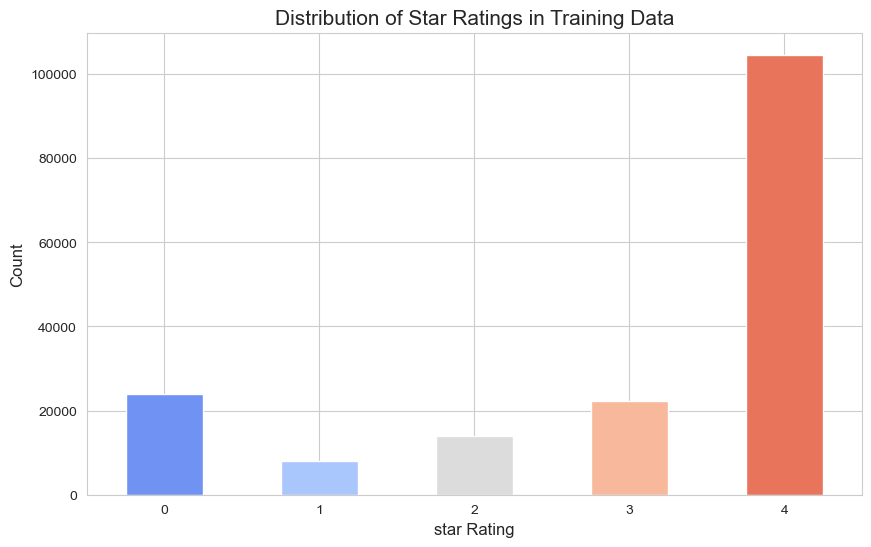

In [17]:
#Counting the number of occurences for each 'star' value , sorting by index
start_counts=training_df['star'].value_counts().sort_index()
plt.figure(figsize=(10,6))
start_counts.plot(kind="bar",color=sns.color_palette('coolwarm',len(start_counts)))
plt.title("Distribution of Star Ratings in Training Data",fontsize=15)
plt.xlabel('star Rating',fontsize=12)
plt.ylabel('Count',fontsize=12)
plt.xticks(rotation=0)

plt.show()

In [10]:
test_df=pd.DataFrame(dataset['test'])
val_df=pd.DataFrame(dataset['val'])

In [29]:
# Star Prediction (sentiment)
# creating the 'prompt' in each dataset (training,validation,and test) by adding a separator '####\n' to the 'review' column.
# this separator is often used in fine-tuning to singnal where the prompt ends and the expceted output begins.
training_df['prompt']=training_df['review']+'\n###\n'
val_df['prompt']=val_df['review']+'\n##\n'
test_df['prompt'] = test_df['review'] +'\n###\n'

## Converting the 'star' column is each dataset to a string format and sotring it in the 'completion' column.
# the 'completion' column will be used as the target variable for sentiment analysis.
training_df['completion']=training_df['star'].astype(str)
val_df['completion']=val_df['star'].astype(str)
test_df['completion']=test_df['star'].astype(str)
## Creating a training dataset in JSONL format after dropping duplicates bases on the 'prompt' column.
## Random sampling ensures the data is shuffled.
training_df.sample(len(training_df)).drop_duplicates(subset=['prompt'])[['prompt','completion']].to_json(
    "D:\\Generative IA\\rag_pdfs\\app-review-full-train-sentiment-random.jsonl",orient="records",lines=True)


In [30]:
val_df.sample(len(val_df)).drop_duplicates(subset=(['prompt']))[['prompt','completion']].to_json(
    "D:\\Generative IA\\rag_pdfs\\app-review-full-val-sentiment-random.jsonl",orient="records",lines=True)

test_df.sample(len(test_df)).drop_duplicates(subset=(['prompt']))[['prompt','completion']].to_json(
    "D:\\Generative IA\\rag_pdfs\\app-review-full-test-sentiment-random.jsonl",orient="records",lines=True)


In [31]:
training_df.head(2)

,package_name,review,date,star,prompt,completion
0,org.ppsspp.ppsspp,Nice😉,March 09 2017,4,Nice😉\n###\n,4
1,com.google.android.gms,Google play service Just one ward its amazing ...,December 18 2016,4,Google play service Just one ward its amazing ...,4


In [96]:
def get_data_dict(row,system=''):
    return {
        "messages":[
            {"role":"system","content":system},
            {"role":"user","content":row['review']},
            {'role':"assistant","content":str(row['star'])}
        ]
    }

In [97]:

        
# export 3.5 prompts with no systeme prompt   
with open(f'D:\\Generative IA\\rag_pdfs\\app-review-full-train-sentiment-random-3.5.jsonl','w') as f:
        for index, row in training_df.iterrows():
            json_str=json.dumps(get_data_dict(row)) # Create a dictionary for each row
            f.write(json_str +'\n')
        
with open(f'D:\\Generative IA\\rag_pdfs\\app-review-full-test-sentiment-random-3.5.jsonl','w') as f:
        for index, row in test_df.iterrows():
            json_str=json.dumps(get_data_dict(row)) # Create a dictionary for each row
            f.write(json_str +'\n')

with open(f'D:\\Generative IA\\rag_pdfs\\app-review-full-val-sentiment-random-3.5.jsonl','w') as f:
        for index, row in val_df.iterrows():
            json_str=json.dumps(get_data_dict(row)) # Create a dictionary for each row
            f.write(json_str +'\n')

In [98]:
system_prompt='You predict star ratings from 0-4 where a is the worst rating and 4 is the best'

In [99]:

        
# export 3.5 prompts with no systeme prompt   
with open(f'D:\\Generative IA\\rag_pdfs\\app-review-full-train-sentiment-random-3.5-system.jsonl','w') as f:
        for index, row in training_df.iterrows():
            json_str=json.dumps(get_data_dict(row,system=system_prompt)) # Create a dictionary for each row
            f.write(json_str +'\n')
        
with open(f'D:\\Generative IA\\rag_pdfs\\app-review-full-test-sentiment-random-3.5-system.jsonl','w') as f:
        for index, row in test_df.iterrows():
            json_str=json.dumps(get_data_dict(row,system=system_prompt)) # Create a dictionary for each row
            f.write(json_str +'\n')

with open(f'D:\\Generative IA\\rag_pdfs\\app-review-full-val-sentiment-random-3.5-system.jsonl','w') as f:
        for index, row in val_df.iterrows():
            json_str=json.dumps(get_data_dict(row,system=system_prompt)) # Create a dictionary for each row
            f.write(json_str +'\n')

In [100]:
training_df['star'].iloc[0]

4

In [101]:
# using OpenAi_s Fine-tuning API
json.loads(open("D:\\Generative IA\\rag_pdfs\\app-review-full-train-sentiment-random.jsonl","rb").readlines()[15])

{'prompt': 'Good I like it\n###\n', 'completion': '4'}

In [102]:
client

In [103]:
#Creating a file object for the validation dataset with openAI
no_system_training_file=client.files.create(
    file=open('D:\\Generative IA\\rag_pdfs\\app-review-full-train-sentiment-random.jsonl',"rb"),purpose='fine-tune')

no_system_val_file=client.files.create(file=open('D:\\Generative IA\\rag_pdfs\\app-review-full-val-sentiment-random.jsonl',"rb"),purpose='fine-tune')


In [112]:

# Initiationg the fine-tuning process with openAI's API

# The client.fine_tuning.jobs.create method is used to start the training
# 'training_file": the id of the uploeded training dataset file.
# validation_file
# 'model': the base model to be fine-tune
# hyperparametres  the number of epochos as
no_system_babbage_job_1=client.fine_tuning.jobs.create(training_file=no_system_training_file.id,
                                                     validation_file=no_system_val_file.id,
                                                        model="babbage-002",
                                                     hyperparameters={'n_epochs':1})

In [127]:
# Retrieving details of an ongoing or completed fine-tuning job using OPen'is API.
# the client.fine_tuning.retrieve.retrieve method fetcg the job details base on its iD
job= client.fine_tuning.jobs.retrieve(no_system_babbage_job.id)
job

FineTuningJob(id='ftjob-05UNtA7FgYwrei0IUboxZbBK', created_at=1729458880, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:babbage-002:personal::AKXgigtW', finished_at=1729459419, hyperparameters=Hyperparameters(n_epochs=1, batch_size=90, learning_rate_multiplier=16), model='babbage-002', object='fine_tuning.job', organization_id='org-8dVUKqYhZ8dX18mhPfv01rZn', result_files=['file-BQjDTm8GZr6HZgmCVHOCUIm1'], seed=1490878798, status='succeeded', trained_tokens=2833557, training_file='file-K29Q3bb9lAfRHDQnX3LcGfK5', validation_file='file-nWvxHc2fyKvEJZQKyCRHYFN3', estimated_finish=None, integrations=[], user_provided_suffix=None)

In [125]:
for event in client.fine_tuning.jobs.list_events(fine_tuning_job_id=no_system_babbage_job.id):
    print(event)
    print("--")

FineTuningJobEvent(id='ftevent-kpRBCLJcS8eOhmbjM6vLFnUK', created_at=1729459425, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message')
--
FineTuningJobEvent(id='ftevent-QD64iowY0wfIXkSNShc7kdjj', created_at=1729459421, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message')
--
FineTuningJobEvent(id='ftevent-m4r1p4DUWgHWm54CKd7ymX5p', created_at=1729459421, level='info', message='Checkpoint created at step 1500', object='fine_tuning.job.event', data={}, type='message')
--
FineTuningJobEvent(id='ftevent-T6V0E75VPiX5iV05AwClHlMc', created_at=1729459413, level='info', message='Step 1501/1501: training loss=0.66', object='fine_tuning.job.event', data={'step': 1501, 'train_loss': 0.6594142317771912, 'total_steps': 1501, 'train_mean_token_accuracy': 0.75}, type='metrics')
--
FineTuningJobEvent(id='ftevent-61LvXTlHZsrGaZJJJERuQCIz', created_at=1729459410, level='info', message=

In [125]:
for event in client.fine_tuning.jobs.list_events(fine_tuning_job_id=no_system_babbage_job.id):
    print(event)
    print("--")

FineTuningJobEvent(id='ftevent-kpRBCLJcS8eOhmbjM6vLFnUK', created_at=1729459425, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message')
--
FineTuningJobEvent(id='ftevent-QD64iowY0wfIXkSNShc7kdjj', created_at=1729459421, level='info', message='New fine-tuned model created', object='fine_tuning.job.event', data={}, type='message')
--
FineTuningJobEvent(id='ftevent-m4r1p4DUWgHWm54CKd7ymX5p', created_at=1729459421, level='info', message='Checkpoint created at step 1500', object='fine_tuning.job.event', data={}, type='message')
--
FineTuningJobEvent(id='ftevent-T6V0E75VPiX5iV05AwClHlMc', created_at=1729459413, level='info', message='Step 1501/1501: training loss=0.66', object='fine_tuning.job.event', data={'step': 1501, 'train_loss': 0.6594142317771912, 'total_steps': 1501, 'train_mean_token_accuracy': 0.75}, type='metrics')
--
FineTuningJobEvent(id='ftevent-61LvXTlHZsrGaZJJJERuQCIz', created_at=1729459410, level='info', message=

In [106]:
# if len(job.result_files):
    

In [128]:
job.result_files

['file-BQjDTm8GZr6HZgmCVHOCUIm1']

In [129]:
# dowloading the results of the completed fine-tuning job using openAI's API.
# the client.file.retreive_content method used to fetch the result files
# job.result_files[0] gets the ID of the first result file associated to the job
results=client.files.content(job.result_files[0])
base64_string=results.read()

decoded_bytes=base64.b64decode(base64_string)
decoded_str=decoded_bytes.decode('utf-8')

with open('D:\\Generative IA\\rag_pdfs\\results.csv','w') as file:
    file.write(decoded_str)
print("csv file created")

csv file created


In [130]:
results_df=pd.read_csv('D:\\Generative IA\\rag_pdfs\\results.csv')
results_df.head()
results_df.shape

(1501, 5)

Text(0.5, 1.0, 'training Loss Over Time')

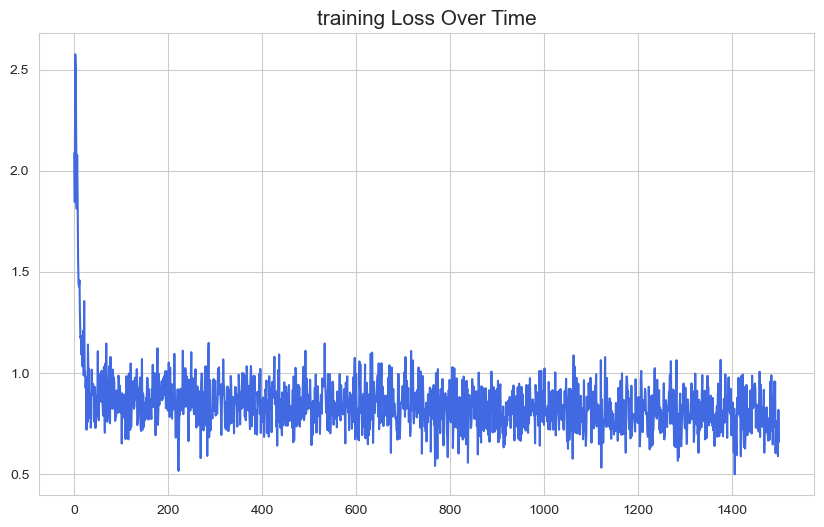

In [131]:
plt.figure(figsize=(10,6))
results_df['train_loss'].dropna().plot(color="royalblue")
plt.title('training Loss Over Time',fontsize=15)


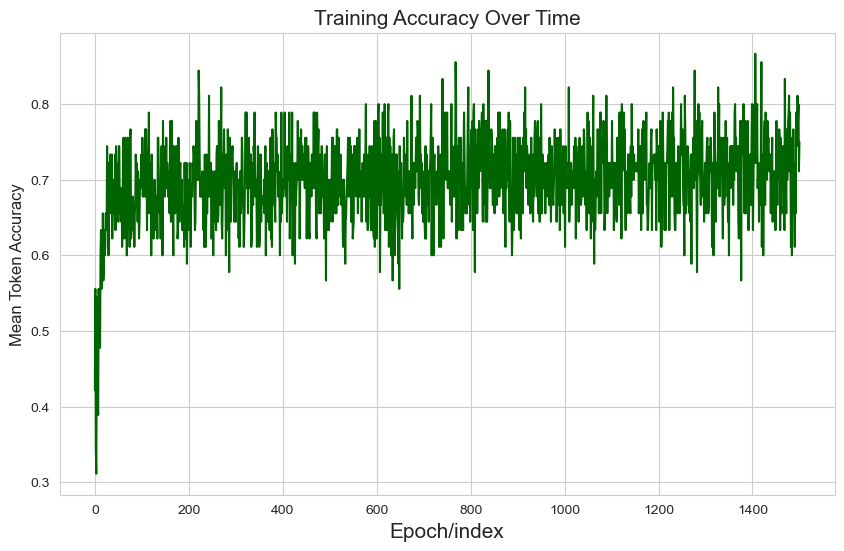

In [132]:
plt.figure(figsize=(10,6))
results_df['train_accuracy'].dropna().plot(color='darkgreen')
plt.title('Training Accuracy Over Time',fontsize=15)
plt.xlabel('Epoch/index',fontsize=15)
plt.ylabel('Mean Token Accuracy',fontsize=12)
plt.show()

In [135]:
# further fine-tune our Babbage model for 3 more epochs
job.fine_tuned_model

'ft:babbage-002:personal::AKXgigtW'

In [ ]:
no_system_babbage_more_epoch_job=client.fine_tuning.jobs.create(
    training_file=no_system_training_file.id,
    validation_file=no_system_val_file.id,
    model=job.fine_tuned_model,
    hyperparameters={'n_epochs':3}
)


RateLimitError: Error code: 429 - {'error': {'message': "This fine-tune request has been rate-limited. Your organization has reached the maximum of 3 active requests (3 running, 0 pending) for the model 'babbage-002'.", 'type': 'invalid_request_error', 'param': None, 'code': 'rate_limit_exceeded'}}

In [141]:
for event in client.fine_tuning.jobs.list_events(fine_tuning_job_id=no_system_babbage_more_epoch_job.id):
    print(event)
    print("--")

FineTuningJobEvent(id='ftevent-8irrcxv4DhA4dH4Jp7fi632F', created_at=1729460070, level='info', message='Step 1046/3166: training loss=0.64', object='fine_tuning.job.event', data={'step': 1046, 'train_loss': 0.6375739574432373, 'total_steps': 3166, 'train_mean_token_accuracy': 0.765625}, type='metrics')
--
FineTuningJobEvent(id='ftevent-qhZ5oKQxHsFuAd35tp4aAiY3', created_at=1729460067, level='info', message='Step 1045/3166: training loss=0.55', object='fine_tuning.job.event', data={'step': 1045, 'train_loss': 0.551735520362854, 'total_steps': 3166, 'train_mean_token_accuracy': 0.796875}, type='metrics')
--
FineTuningJobEvent(id='ftevent-plTGTHljzs4mO7xLiTsDmrLa', created_at=1729460067, level='info', message='Step 1044/3166: training loss=0.83', object='fine_tuning.job.event', data={'step': 1044, 'train_loss': 0.8277472853660583, 'total_steps': 3166, 'train_mean_token_accuracy': 0.7265625}, type='metrics')
--
FineTuningJobEvent(id='ftevent-71OFCVwrPaZ9qrOumaXYmOoy', created_at=1729460067

je suis la
   step  train_loss  train_accuracy  valid_loss  valid_mean_token_accuracy
0     1     2.08740         0.42222         NaN                        NaN
1     2     1.84441         0.55556         NaN                        NaN
2     3     2.57538         0.34444         NaN                        NaN
3     4     2.50209         0.31111         NaN                        NaN
4     5     2.16442         0.46667         NaN                        NaN


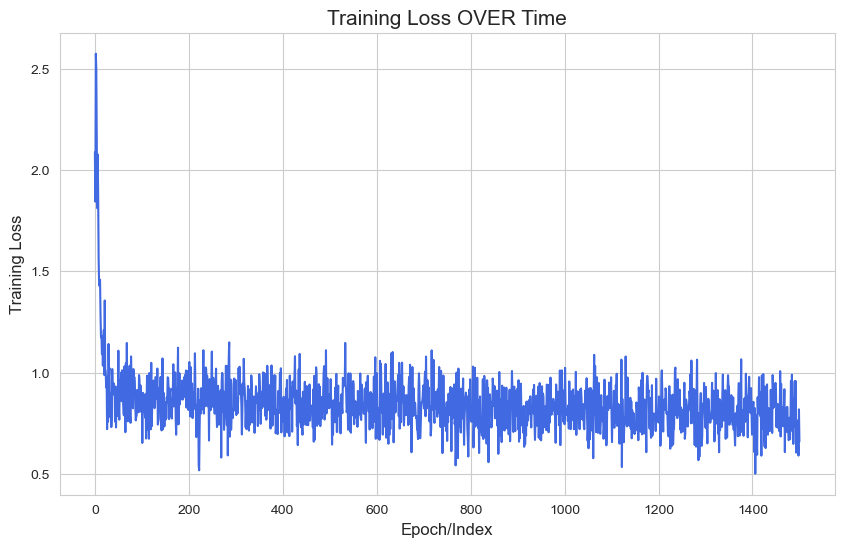

In [146]:
job=client.fine_tuning.jobs.retrieve(no_system_babbage_more_epoch_job.id)
results_df =None
if len(job.result_files):
    print("je suis la")
    resutls=client.files.content(job.result_files[0])
    base64_string=results.read()
    decoded_bytes=base64.b64decode(base64_string)
    decoded_str=decoded_bytes.decode('utf-8')

    with open('D:\\Generative IA\\rag_pdfs\\results.csv','w') as file:
        file.write(decoded_str)
    results_df=pd.read_csv('D:\\Generative IA\\rag_pdfs\\results.csv')
   
print(results_df.head())
plt.figure(figsize=(10,6))
results_df['train_loss'].dropna().plot(color="royalblue")
plt.title('Training Loss OVER Time',fontsize=15)
plt.xlabel('Epoch/Index',fontsize=12)
plt.ylabel('Training Loss', fontsize=12)

plt.show()
    

In [152]:
# training no systeme propmpt 
json.loads(open("D:\\Generative IA\\rag_pdfs\\app-review-full-train-sentiment-random-3.5.jsonl","rb").readlines()[0])

{'messages': [{'role': 'system', 'content': ''},
  {'role': 'user', 'content': 'Nice😉'},
  {'role': 'assistant', 'content': '4'}]}

In [153]:
no_system_training_file_3_5=client.files.create(file=open("D:\\Generative IA\\rag_pdfs\\app-review-full-train-sentiment-random-3.5.jsonl","rb"),purpose="fine-tune")

In [154]:
no_system_val_file_3_5=client.files.create(file=open("D:\\Generative IA\\rag_pdfs\\app-review-full-val-sentiment-random-3.5.jsonl","rb"),purpose="fine-tune")

In [158]:
gpt_3_5_no_system_job= client.fine_tuning.jobs.create(training_file=no_system_training_file_3_5.id,
                                 validation_file=no_system_val_file_3_5.id,
                                                      model="davinci-002",
                                                      hyperparameters={"n_epochs":1}
                                                     )

gpt_3_5_no_system_job.id


BadRequestError: Error code: 400 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details.', 'type': 'invalid_request_error', 'param': None, 'code': 'exceeded_quota'}}